In [124]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from statistics import mean
import pandas as pd

In [3]:
# генерация случайного вектора размерности size со значениями в интервале [0,lam)
def gen_index(lam,size):
    return np.random.randint(0,lam,size)

In [4]:
# np.random.randint(0,5,10)

In [12]:
def func_p0(lam, c, mu):
    sum = 0
    for i in range(c+1):
        sum+=pow(lam,i)/(pow(c,i)*pow(mu,i))
    return sum
print(1/func_p0(4,4,6))

0.8334405144694534


In [240]:
# Задача массового обслуживания с N аппаратами и возможностью совместного обслуживания заявок аппаратами, нет очереди

# количество каналов
n = 4

lam = 4 # интенсивность поступления заявок
mu = 6 # интенсивность обработки заявок

time_0 = 0.0 # начало отсчета
time_1 = 10.0 # конец времени
time_h = 0.001 # шаг
kol_time = math.floor((time_1-time_0)/time_h-1) #количество точек
index_r = 0
# Среднее время обслуживания в минутах
handle_time = 1/(n*mu)
print(handle_time)
quantity_experiments = 1000

# рассматриваем промежуток в 5 секунд
# пусть у нас есть 4 канала, каждая заявка приходит в случайное время и длится случайное количество времени
# количество заявок в рассматриваемый промежуток времени 
minutes_for_model = 100
matrix_active =  np.zeros(kol_time+1)
tmp = 0
for vse in range(quantity_experiments):

    # Массив со временами поступления заявок в минутах отсчитывамых с нуля
    requests = []
    last_request_time = 0.0
    for minute in range(0, minutes_for_model):
        rnd = random.expovariate(lam)
        last_request_time += rnd
        requests.append(last_request_time)

    requests.sort()  # Выставим звонки в порядке возрастания
    handles = []  # Время необходимое для обработки каждой из поступивших заявок
    lambd = 1/handle_time # Интенсивность потока для времени разговора

    for request in requests:
        rnd = random.expovariate(lambd)
        handles.append(rnd)
    count_active = [0] # np.array([0]) # начальное количество активных заявок
    index_r = 0
    for i in np.arange(time_0+time_h,time_1,time_h):
        act = 0 # на каждом интервале заново считаем количество активных заявок
        index_act = [] # вектор номеров активных заявок
        efficiency = 0 # доля заявки, приходящаяся на каждый канал

        while i >= requests[tmp]: # может тут while? потому что вдруг в один интервал, в очень близое время, но по очереди придут 2 заявки. Понятно, что сначала разберемся с одной. Но переходить сразу после этого на другой промежуток времени, не проверив следующие заявки, не очень правильно
            # сюда мы заходим, если заявки поступили до текущего момента времени i.
            # Создаем вектор эффективностей, активных заявок и их количества.
            if handles[tmp]>0: 
                # если время до завершения работы над заявкой еще не закончилось, то работаем над ней
                # 1) Если все n каналов свободны, т.е. нет еще активных
                if act == 0:
                    act += 1 
                    # теперь в работе будет одна заявка, при этом:
                    efficiency = 1/n 
                    # эффективность каждого канала = 1/n.
                    index_act.append(tmp)
                # 2) Если уже все n каналов работают над n заявками и поступает следующая, то она игнорится, не выполняется, поэтому сразу ее откидываем, приравнивая время на ее выполнение к 0
                if act == n:
                    # act и index_act останутся прежними
                    efficiency = 1 
                    # Каждый канал работает над своей заявкой
                    handles[tmp] = 0 
                    # Обнуляем время поступившей заявки, над которой работать не будем
                # 3) В работе уже имеется какое-то количество заявок, не один из крайних случаев
                if act > 1 and act < n:
                    act += 1 
                    # заявок станет на одну больше
                    index_act.append(tmp) 
                    # записываем номер новой заявки
                    efficiency = act/n
            tmp += 1
            # конец while

        # размерность вектора индексов активных заявок должна совпасть с их количеством
        # Теперь у нас есть список активных заявок в данный период. Среди них уже распределяем каналы по заявкам в случайном порядке и можем вычислить на основе нее сколько на данном промежутке времени отработаем по каждой из активных заявок и вычтем это время из оставшегося с предыдущих этапов
        if act != 0:
            chan = gen_index(act,n) 
            # генерируем случайное распределение заявок по каналам
            while len(np.unique(chan)) != act: 
                # на случай, если будут распределены не все заявки
                chan = gen_index(act,n)
            unique, count = np.unique(chan, return_counts=True)
            work_time_i = count*efficiency*time_h 
            handles= np.array(handles)
            handles[index_act] -= work_time_i 
            # вектор оставшегося времени обслуживания всех заявок изменяется для активных. Если станет <=0,то заявка считается выполненной

        # ищем теперь новый index_r, начиная с меньшего номера из тех, оставшееся время выполнения которых >0 для запуска следующего интервала времени
        tmp = int(np.argwhere(handles > np.zeros(len(handles)))[0])
        # теперь добавляем в вектор величину количества активных заявок на рассматриваемом маленьком интервале времени
        count_active.append(act)
    matrix_active = np.vstack([matrix_active,[count_active]])



0.041666666666666664


In [241]:
matrix_active = matrix_active[1:]
# print(len(matrix_active))
table = pd.DataFrame(matrix_active)
print(table.head())
m0_list = []
main_list = []
# m1_list = []
# m2_list = []
# m3_list = []
# m4_list = []
for t in range(0,n+1): 
    for i in table.columns:
        m0_list.append(np.sum(table[i].values == t)/quantity_experiments)
    main_list.append(m0_list)
    m0_list = []



   0     1     2     3     4     5     6     7     8     9     ...   9990  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    1.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

   9991  9992  9993  9994  9995  9996  9997  9998  9999  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 10000 columns]


5
1
2
3
4
5


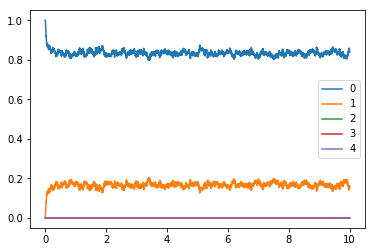

In [242]:
count_ = 0
print(len(main_list))
for i in main_list:
#     print(i)
    plt.plot(np.arange(time_0,time_1,time_h), i, label = count_)
    count_=count_+1
    print(count_)
plt.legend()
plt.show()